# Unsupervised Learning and Dimensionality Reduction

## Introduction

The goal of the previous analysis was finding the models (function approximations) that map some unseen data to most likely outcome. Supervized algorithms which were applied to the task provided predictive power measarable by ratio of correct answers. However, even the most accurate models revealed little about the structure of the data. Unsupervized algorithms help fill out this gap by providing means of finding subpopulations within the data by estimating distributions of data over different clusters.

In [2]:
%matplotlib inline
from algo_evaluation.handle_imports import *
from algo_evaluation import handle_importsndle_imports

## Classification Data Review

__Higgs Data quick review__:

   - given outcomes of particle decays, detect Higgs boson particle (signal); 
   
   - most of the __supervised__ algorithms gave acceptable accuracy ranging from __0.8 - 0.9__ and far outperforming the __backpropagation__ algorithm for neural networks (__0.5__ which is as good as flip of the coin but a lot more computationaly expensive)
   
   - __learning weights__ with Randomized Optimization algorithms improved accuracy of the neural network to __0.7__ and higher (genetic algorithm)
   
__Additional Data Wrangling__:

   - features were __rescaled__ as a requirement to feature transformation alogrithms
   
   - previously manually pruned features were put back to allow feature selection algorithms to autotically choose the most informative ones
   
   - dataset was not reduced in size since dimensionality reduction provides speed advantage (the main reason for sampling records in the previous analysis)

In [18]:
higgs_data = datasets.load_higgs_train(sample_size=None, verbose=True, scale=True, 
                                       prune_features=False)
all_higgs_features = higgs_data[0].shape[1]

Size of the dataset: 68114
Number of features: 30
Number of positives (signal): 31894
Number of negatives (background): 36220


__Converters Data quick review__:

   - given online users' behavior and preferences predict whether or not ad display will result in conversion; 
   
   - in contrast to Higgs dataset, supervized algorithm on this datataseprovided high accuracy >94%
   
   - converters dataset as a result was not subjected to randomized optimization analysis

In [392]:
bid_data = datasets.load_bidding_train(verbose=True, scale=True)
all_bid_data_features = bid_data[0].shape[1]

Size of the dataset: 57970
Number of features: 15
Number of converters: 399
Number of non-converters: 54615
Number of leads: 2956


## K-means Clustering

Evaluating cluster performance is different from the techiques used in Supervised Algorithms where accuracy was estimated roughly as a count of wrong answers. For clustering we must imploy similarity metric: did clustering define separations of data similar to ground truth. Here I shall use __Adjusted Rand Index__ that measures the similarity of the two assignments, ignoring permutations and with chance normalization.

#### Model Selection (cluster complexity)

Best model is selected by iterating over the number of clusters and measuring the performance of each with ARI score.

In [350]:
df_kmeans_higgs = kmeans_eval.estimate_clusters(higgs_data)

In [367]:
df_kmeans_converters = kmeans_eval.estimate_clusters(bid_data)

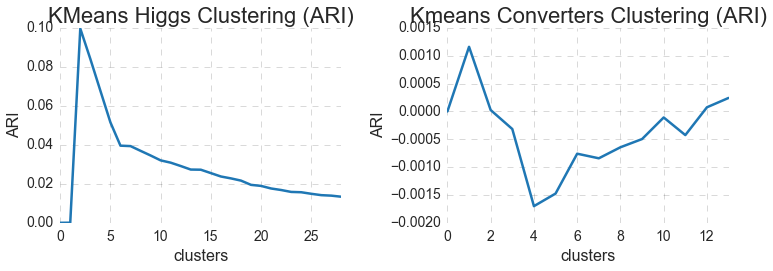

In [368]:
plot_cluster_estimation.plot_kmeans_cluster_score(df_kmeans_higgs, df_kmeans_converters)

__Choosing K__: 

Best data separation for __Higgs__ data achieved with number of clusters equal __2__ which makes sense since there are two classes in the data: signal and background, so the clustering lined up with labels. As number of the clusters grow, similarity measure gradually approaches zero and uniformity of the data withing each group decreases.

__Converters__ dataset achieves best separation for a single class which is the same as saying that clustering algorithm could not split data into groups. Since a single cluster does not make sense, it is reasonable to analyze next best separation. There is no clear convergence in this case towards a certain number of clusters and moreover, cluster assighment does not line up with labels, so it is ok to choose an arbitrary number (we can stick with __10__ and see how well that compares with dimensionality reduction algorithms) 

__Insight__: Neither of the above data separation is considered good (ARI=1.0 is a perfect score). Since scores are close to 0.0, label assignment is rather uniform especially for converters data. This suggests that datasets have more complex structure and are not easily separable into groups.

## Expectation Maximization

As a second approach to clustering we will use the probabilistic model with assumption that all data points are generated from the number of Gaussian distributions. As a measure metric, we can use the scoring method which computes the __log probability__ under the model. 

In [355]:
df_gmm_higgs = gmm_eval.estimate_clusters(higgs_data)

In [369]:
df_gmm_converters = gmm_eval.estimate_clusters(bid_data)

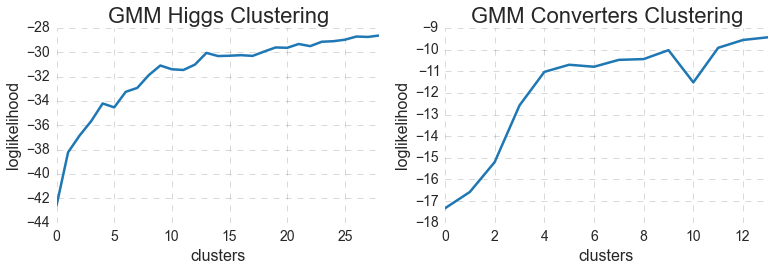

In [370]:
plot_cluster_estimation.plot_gmm_cluster_score(df_gmm_higgs, df_gmm_converters)

For __Higgs__ dataset, loglikelihood of data is increasing as number of latent variables (here number of gaussian distributions) is increasing which suggests that every single feature came from a gaussian distribution with unique paramters (means and variances).

For __Converters__ dataset, loglikelihood is increasing as well, however it is important to note that in the range of clusters from 4 to 9 probability increase is not very significant, so it is ok to make an assumption that data generally comes from 4 distinct distributions. 

## Feature Selection and Transformation for Higgs Dataset

In the previous analysis Higgs records were sampled and features were manually pruned due to the slow speed of supervized algorithms. In this analysis, complete dataset is restored to take advantage of automatic feature selection using dimensionality reduction algorithms.

Dimensionality reduction is the task of deriving a set of features that is smaller than the original feature set while retaining most of the variance of the original data. 
To estimate the best number of components to be used for data transformation, I used __data variance__ and __reconstruction error__ analysis to choose optimal setting.

### Principal Component Analysis (PCA)

In [162]:
pca_rank = pca_eval.rank_features(higgs_data, n_components=all_higgs_features)

PCA estimates percentage of variance explained by each of the components. I extracted those variances (eigen values) for each feature and sorted them from largest to smallest. Visualizing the results made it clear that "Derived" features from Hiigs dataset have larger spread than "Primitives" and thus are more informative for classification. This supports the decision made in the previous analysis where "Primitive" features were pruned based on feature by feature analysis.

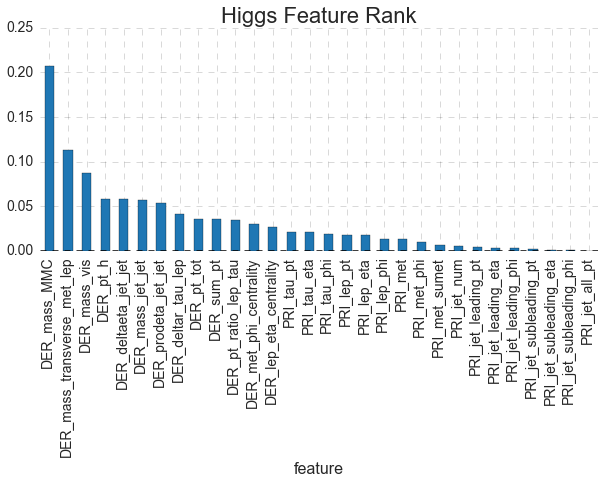

In [282]:
pca_eval.plot_rank(pca_rank, title='PCA Component Selection (eigen values)')

__Reducing features while retaining data variance__:

When applying dimensionality reduction, it is important to retain certain threshold of data variance. In addition to visual inspeaction, I selected features which retained __95%__ of data variance (dimensionality reduced from 30 to 7).
Algorithm ranked features _DER_mass_MMC_ the highest which makes sense since this feature estimates mass of the Higgs boson candidate and indeed is the most informative.

In [168]:
reduced_features = pca_rank.variance_ratio[pca_rank.variance_ratio > 0.05]
reduced_features

feature
DER_mass_MMC                   0.207485
DER_mass_transverse_met_lep    0.112727
DER_mass_vis                   0.087133
DER_pt_h                       0.058547
DER_deltaeta_jet_jet           0.058122
DER_mass_jet_jet               0.057542
DER_prodeta_jet_jet            0.053497
Name: variance_ratio, dtype: float64

### Independent Component Analysis (ICA)

By minimizing the Gaussianity of the projection, ICA is designed to recover the underlying physical process which generated the observed data. Selecting number of components for ICA dimensionality reduction can be achieved by using a criteria which determines how close to gaussian is the feature distribution.

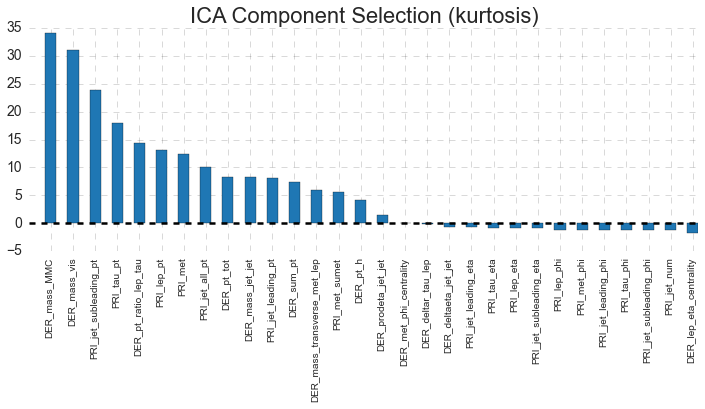

In [35]:
ica_comp = ica_eval.estimate_components(higgs_data, display=True)

__Insight__: Half of the features have kurtosis value close to 0 which means that their distribution is very close to Gaussian and thus those features are less likely to be the sources of underlying physical process. Note that _DER_mass_MMC_ is again the top feature so it is becoming more likely that this feature is the best component to be selected among other 14 (based on the selection criteria: kurtosis > 5.0)

To get an intuition on how ICA is reconstructing the signal, I visualized the estimated mixing matrix as a heat map to see how much the actual outcomes of physical processes for colliding particles are mixed in the observable features. Note, that overall, the data is not too muddy which means a lot of features are independed (there are more light that dark areas)

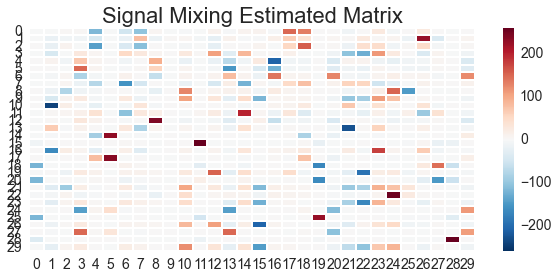

In [49]:
mm = ica_eval.mixing_matrix(higgs_data, all_higgs_features, display=True)

### Randomized Component Analysis (RCA)

When processing time and model simplicity is more important than accuracy, then data dimension can be reduced using randomized projections which is computationally the most efficient and it works!

In [8]:
reload(handle_imports)

<module 'algo_evaluation.handle_imports' from '/Users/sshegheva/workspace/bag-of-algorithms/algo_evaluation/handle_imports.pyc'>

In [623]:
projections = rand_projections.project_features(higgs_data, all_higgs_features, display=True)

In [628]:
projections.components_

<30x30 sparse matrix of type '<type 'numpy.float64'>'
	with 159 stored elements in Compressed Sparse Row format>

## Feature Selection and Transformation for Converters Dataset

Same principles and technique were applied to select features for converters dataset (retaining data variance of 95%)

In [251]:
pca_rank_bid = pca_eval.rank_features(bid_data, n_components=all_bid_data_features)

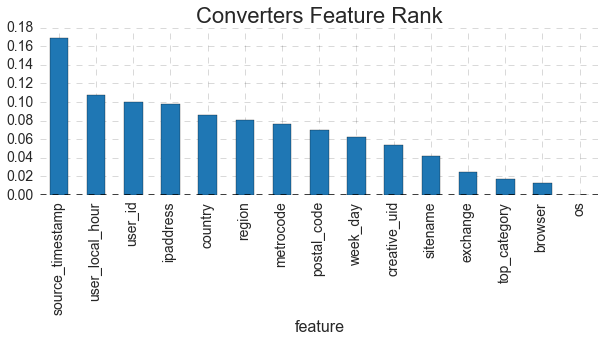

In [284]:
pca_eval.plot_rank(pca_rank_bid, title='Converters Feature Rank', figsize=(10,3))

In [593]:
red_conv_feat = pca_rank_bid.variance_ratio[pca_rank_bid.variance_ratio > 0.05]
reduced_conv_dimension = len(red_conv_feat)
print 'Estimated number of reduced components =', reduced_conv_dimension
print red_conv_feat

Estimated number of reduced components = 10
feature
source_timestamp    0.168507
user_local_hour     0.107505
user_id             0.100265
ipaddress           0.097562
country             0.085957
region              0.080283
metrocode           0.076695
postal_code         0.069630
week_day            0.062470
creative_uid        0.054318
Name: variance_ratio, dtype: float64


__Insight__: Some of features (like sitename) were pruned by not contributing to data spread (small eigen value); this suggests that the local user time is more important differentiator as to whether or not ad will result in conversion.

## Neural Networks on Higgs dataset post Dimensionality Reduction

In the following experiment setup Higgs data set is reduced using four algorithms: PCA, ICA, RCA and LSA. Same error measure is applied as in the previous analysis where Higgs boson was classified with Neural Networks.
I chose to visualize the classification error along side with dimensionality reduction time to see the tradeoff between the speed and model accuracy.

In [408]:
df_nn = nn.evaluate_nn_accuracy(higgs_data, reduced_higgs_dimension)

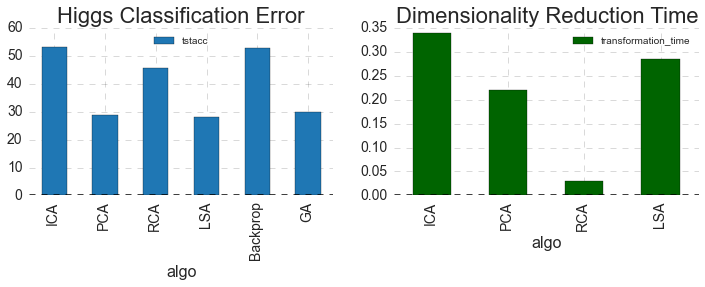

In [468]:
nn.plot_evaluation(df_nn)

In addition to comparing the classification error between different dimensionality reduction algorithms, I added results from previous two algorithms (Backpropagation and Weights Learning with Genetic Algorithm) to be used as a baseline. 

Very notable is the fact that __PCA__ dimension reduction has improved classification error as compared to Backpropagation and is on par with Genetic Algorithm which performed best for learning weights. Reducing dimensions with randomized projection (__RCA__) does have not the best accuracy, however the speed of the algorithm is amazingly fast compared to all others and so it can be very beneficial in the cases accuracy could be sacrificed to avoid the curse of dimensionality.

## Clustering post Dimensionality Reduction

Here I repeat the clustering experiments with projected data which in both dataset if smaller than the original dimensionality: Higgs (30 -> 7) and Converters (15 -> 10).
Neither Kmeans or GMM showed a different structure on the projected datasets (see figure below), so the same insights about data distribution are preserved.

In [464]:
df_higgs_dim = clustering.evaluate_higgs_clustering(higgs_data, reduced_higgs_dimension)

In [476]:
df_conv_dim = clustering.evaluate_conv_clustering(bid_data, reduced_conv_dimension)

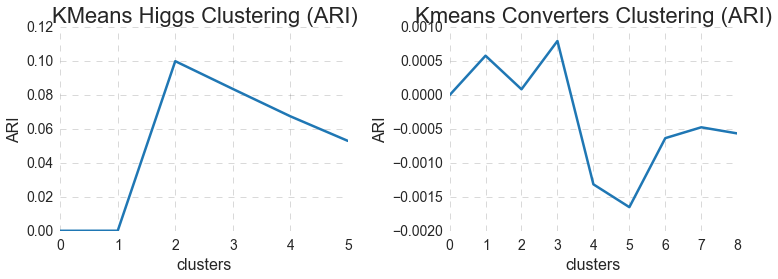

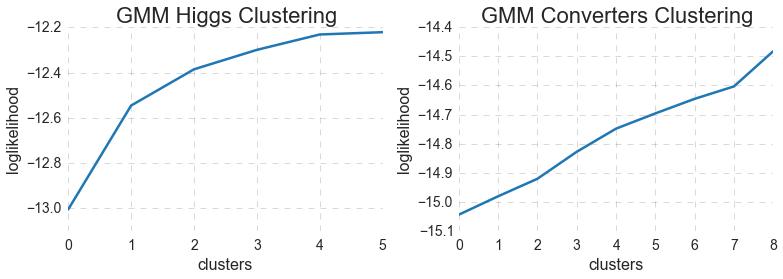

In [486]:
clustering.plot_cluster_performance(df_higgs_dim, df_conv_dim)

__Runtime comparsion of the clustering time__

Another benefit of feature transformation algorithms (besides knowledge discovery) is the __speed__ gain after projecting the original data to reduced dimensions. 

Higgs clustering experiment: Reduce the data dimension from 30 to 7 and compare Kmeans and GMM clustering runtime before and after (2 clusters - signal and background). Both gained in speed improvement without loss of the data structure (even the slowest feature transformation algorithm proved to be beneficial to overal time saving)

Convertes clustering experiment: Reduce the data dimension from 15 to 10 and compare Kmeans and GMM clustering runtime before and after (3 clusters - converters, lead and non-converters). In order to preserve the original data structure (retaining 95% of variance), converters dataset dimensionality was not reduced as much as Higgs dataset. Note that in this case, projecting data to new dimensions and re-estimating the distribution is actually slower and thus there is no real benefit in transforming data other than visualization.  

In [552]:
higgs_time_df = clustering_dim_reduction.compare_cluster_runtime(higgs_data, 2, 7)

In [553]:
conv_time_df = clustering_dim_reduction.compare_cluster_runtime(bid_data, 3, 10)

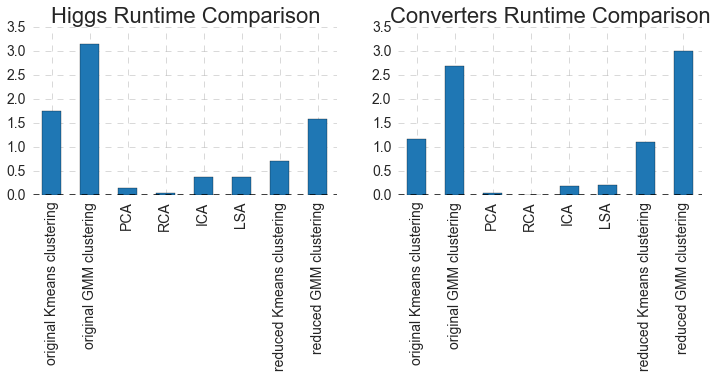

In [554]:
clustering_dim_reduction.plot_running_time(higgs_time_df, conv_time_df)

## Neural Networks on Higgs dataset post Clustering as Dimensionality Reduction

To recapitulate this final experiment, following reductions were done:

  - Project the original dataset of 30 features to new dataset of 7 features where 95% of data variance is retained.
  - Run Kmeans Clustering with 2 clusters as suggested by model complexity analysis and add cluster-distance spaces as new features.
  - Run GMM distribution estimation with 4 components as suggested by model analysis and add distribution estimation as a new feature to PCA projected set
  - Rerun neural network classification with 9D (7 features + 2 cluster-distance space features) and 8D (7 features + 1 distribution assighment) data dimension

In [581]:
higgs_data_9d, _ = clustering_dim_reduction.kmeans_transform(higgs_data, 2, 7)

In [582]:
higgs_data_8d, _ = clustering_dim_reduction.gmm_transform(higgs_data, 4, 7)

In [583]:
_, _, err_9d = clustering_dim_reduction.neural_net_post_clustering(higgs_data_9d)

In [584]:
_, _, err_8d = clustering_dim_reduction.neural_net_post_clustering(higgs_data_8d)

In [592]:
err = pd.Series([28.739212, err_9d, err_8d], index=['Error on PCA reduced data',
                                                    'Error with new features added by KNN',
                                                   'Error with new features added by GMM'])
err

Error on PCA reduced data               28.739212
Error with new features added by KNN    29.281965
Error with new features added by GMM    28.485630
dtype: float64

No significant error improvement is measured during this phase of the experiment, so the advantage here will be speed gain only.

If you used data that already had labels (for example data from a classification problem from assignment #1) did the clusters line up with the labels? Do they otherwise line up naturally? Why or why not? Compare and contrast the different algorithms. What sort of changes might you make to each of those algorithms to improve performance? How much performance was due to the problems you chose? Be creative and think of as many questions you can, and as many answers as you can. Take care to justify your analysis with data explictly.
Can you describe how the data look in the new spaces you created with the various aglorithms? For PCA, what is the distribution of eigenvalues? For ICA, how kurtotic are the distributions? Do the projection axes for ICA seem to capture anything "meaningful"? Assuming you only generate k projections (i.e., you do dimensionality reduction), how well is the data reconstructed by the randomized projections? PCA? How much variation did you get when you re-ran your RP several times (I know I don't have to mention that you might want to run RP many times to see what happens, but I hope you forgive me)?
When you reproduced your clustering experiments on the datasets projected onto the new spaces created by ICA, PCA and RP, did you get the same clusters as before? Different clusters? Why? Why not?
When you re-ran your neural network algorithms were there any differences in performance? Speed? Anything at all?
It might be difficult to generate the same kinds of graphs for this part of the assignment as you did before; however, you should come up with some way to describe the kinds of clusters you get. If you can do that visually all the better.
